In [1]:
import numpy as np
import h5py
from copy import deepcopy
import os, zipfile, shutil,gzip
import pandas as pd
import glob
from scipy.stats import linregress
import os
from datetime import datetime
from datetime import timedelta
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import scipy
from numpy import polyfit, poly1d
from scipy import interpolate
import matplotlib as mpl
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import time
from tqdm import tqdm
import math
import plotly
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import json
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
from scipy import interpolate

secret='TD.a-ZsKkoLFWpWQpFK.dejlvOF7NK0XBVM.LlD63gOWm7VaNIu.WzC3t3XtgjavrVM.PxZSkA5B3pBRC2T.baP4'
import nest_asyncio
nest_asyncio.apply()
from tardis_dev import datasets

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [7]:
datasets.download(
            exchange='kraken',
            data_types=[
                'book_snapshot_5'
            ],
            from_date='2022-11-08',
            to_date='2022-11-09',
            symbols=['USDC-USDT'],
            api_key=secret,
        )

In [5]:
def time_df(name,path,time_type='ms'):
    os.chdir(path)
    df=pd.read_csv(f'./{name}')
    f_gettime = lambda x: datetime.fromtimestamp((x) / 1000000)  ##get datatime_type
    df['time'] = df.timestamp.map(f_gettime).astype(f'datetime64[{time_type}]')
    return df

In [6]:
def clean_df(df):
    if 'asks[0].price' in df.columns:
        df=df.rename(columns={'asks[0].price':'ask1','bids[0].price':'bid1'})
        cb=False
    else:
        df=df.rename(columns={'ask_price':'ask1','bid_price':'bid1'})
        df['symbol']='USDT/USD_cb'
        cb=True
    df=df[['time','ask1','bid1','symbol']]
    df['mp']=(df['ask1']+df['bid1'])/2
    if cb==True:
        df['mp']=1/df['mp']
    return df[['time','mp','symbol']].dropna()

In [4]:
def find_error(df,min_gap=10,lim_rate=0.6):    
    lim=np.max(df['vol'])*lim_rate
    isout_time=df[df.vol>lim]
    df.index=df.time
    time_se=isout_time.index
    if time_se.empty:
        return []
    error_score={}
    score=isout_time[isout_time.time==time_se[0]]['vol'][0]
    time=[time_se[0]]
    is_inscore=False
    for i in range(1,len(time_se)):
        if time_se[i]-time_se[i-1]>timedelta(seconds=min_gap):
            error_score[score]=time
            score=isout_time[isout_time.time==time_se[i]]['vol'][0]
            time=[time_se[i]]
            is_inscore=True
        else:
            score+=isout_time[isout_time.time==time_se[i]]['vol'][0]
            time.append(time_se[i])
            is_inscore=False
    
    if is_inscore==False:
        error_score[score]=time
    bid=np.max(list(error_score.keys()))
    time_region=[error_score[bid][0],error_score[bid][-1]]
    return time_region

In [18]:
def time_plot(df,time_shot):
    left=time_shot+timedelta(hours=-3)
    right=time_shot+timedelta(hours=1)
    dt=df[df.time>=left]
    dt=dt[dt.time<=right]
    date=str(time_shot).replace(' ','_').replace(':','')
    
    plt.figure(figsize=(15,8))
    plt.plot(dt.time,dt['mp'])
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/{date}.jpg')

In [8]:
def comp_plot(df):
    df=df.reset_index()
    left='2022-11-09 03:30:00'
    right='2022-11-09 07:20:00'
    dt=df[df.time>=left]
    dt=dt[dt.time<=right]
    date=left.replace(' ','_').replace(':','')
    
    plt.figure(figsize=(15,8))
    for symbol in ['USDC/USD','USDT/USD','USDT/USD_cb','BUSDUSDT','USDC/USDT']:
        plt.plot(dt[df['symbol']==symbol].time,dt[df['symbol']==symbol]['mp'],label=symbol)
    plt.legend()
    plt.savefig(f'C:/Users/杜威/Desktop/tardis/comp/7_{date}.jpg')

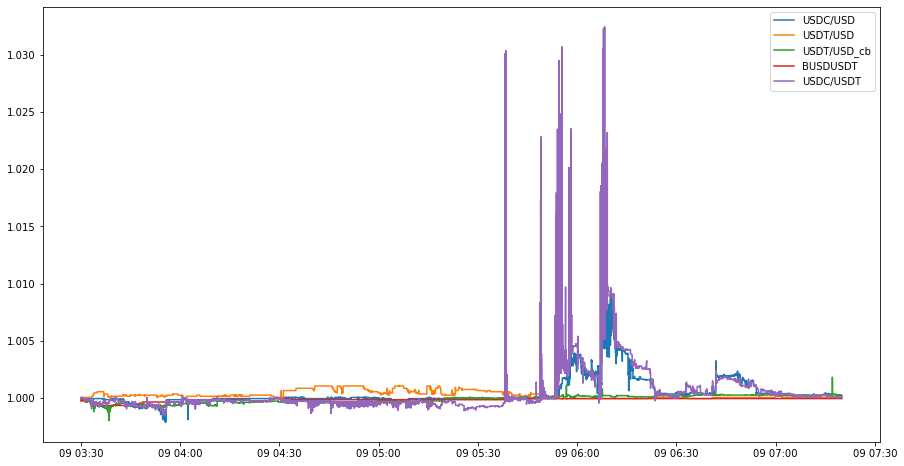

In [11]:
comp_plot(df)

In [5]:
dt=df[df.time>'2022-03-13']
dt['time']=dt['time'].astype('datetime64[m]')
dt=dt.groupby('time',as_index=False).var()

In [6]:
time_ls=dt.sort_values(by='mp',ascending=False).dropna().head(20)
time_ls=time_ls.reset_index()

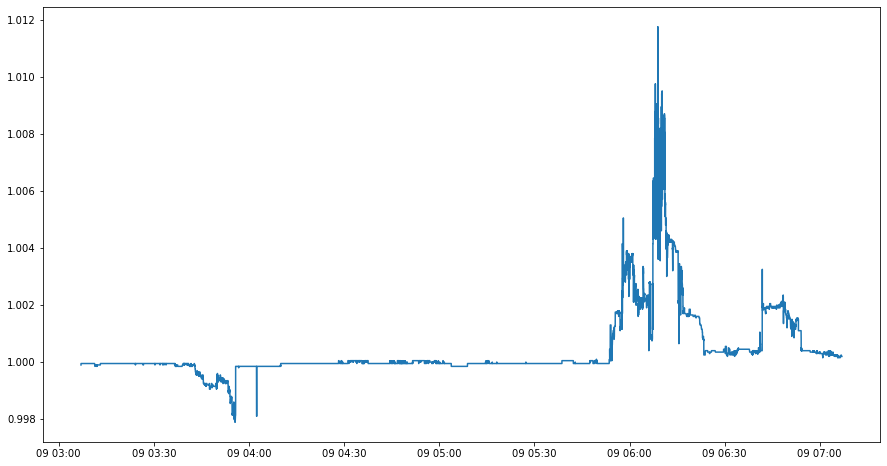

In [19]:
for shot in time_ls['time'][:1]:
    time_plot(df,shot)

In [10]:
path=r'C:\Users\杜威\Desktop\datasets'
dt=[]
for name in os.listdir(path):
    if ('USDC-USD' in  name or 'USDT-USD' in name or 'BUSDUSDT' in name or
       'USDC-USDT' in name) and ('snap' in name or 'ticker' in name) and '2022-11-08' in name:
        df=time_df(name,path)
        df=clean_df(df)
        dt.append(df)
df=pd.concat(dt)
df

,time,mp,symbol
0,2022-11-08 08:00:01.466,0.99985,BUSDUSDT
1,2022-11-08 08:00:01.462,0.99985,BUSDUSDT
2,2022-11-08 08:00:01.562,0.99985,BUSDUSDT
3,2022-11-08 08:00:01.662,0.99985,BUSDUSDT
4,2022-11-08 08:00:01.762,0.99985,BUSDUSDT
...,...,...,...
166899,2022-11-09 07:59:54.603,0.99995,USDT/USD
166900,2022-11-09 07:59:55.525,0.99995,USDT/USD
166901,2022-11-09 07:59:55.711,0.99995,USDT/USD
166902,2022-11-09 07:59:57.528,0.99995,USDT/USD
